# 4-14. 프로젝트: 나만의 이미지 분류기 만들어보기

tf_flowers 데이터셋으로 모델을 학습시켰다. 모델은 LMS 학습 시 주어졌던 VGG16 + 재구성한 classifier를 그대로 사용했다. Flatten 대신 Global Average Pooling을 사용했다. 해당 데이터의 클래스가 5개이므로, 마지막 Dense() 레이어의 unit 수를 5개로 설정했다. learning rate는 0.001로 바꿨고, validation step은 10으로, epoch는 5로 각각 줄였다. 모델 컴파일 시 optimizer는 LMS에 예시로 나왔던 RMSprop을 그대로 사용했다.

학습 결과 validation accuracy가 epoch 5번 만으로도 0.8을 넘어섰다. 20개에 대한 정확도를 계산해보니 95%가 나왔다.

## 필요한 모듈 import

In [1]:
import warnings

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

import numpy as np
import matplotlib.pyplot as plt

## 데이터셋 내려받기

In [2]:
warnings.filterwarnings("ignore")

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True, as_supervised=True
) # https://www.tensorflow.org/datasets/catalog/tf_flowers

# 데이터셋 확인
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


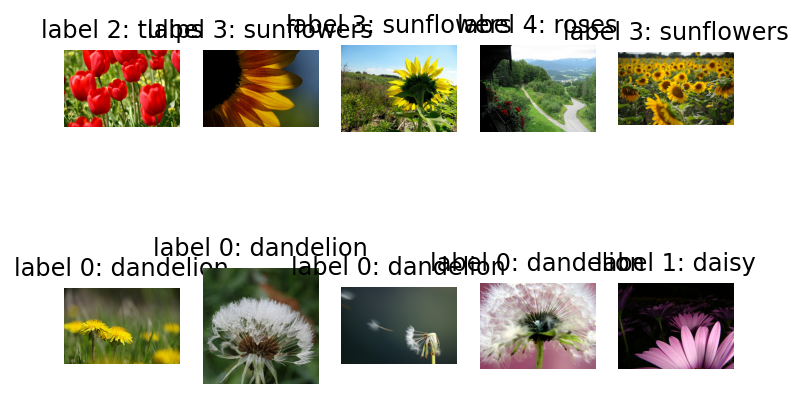

In [3]:
# 데이터 확인
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

## 모델에 넣을 수 있는 형태로 데이터셋 준비

In [4]:
# 같은 크기로 formatting
IMG_SIZE = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1 # 픽셀 값 범위 변경: 0~255 -> -1~1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

# train_batches, validation_batches, test_batches
BATCH_SIZE = 20 # 변경: 32 -> 20
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

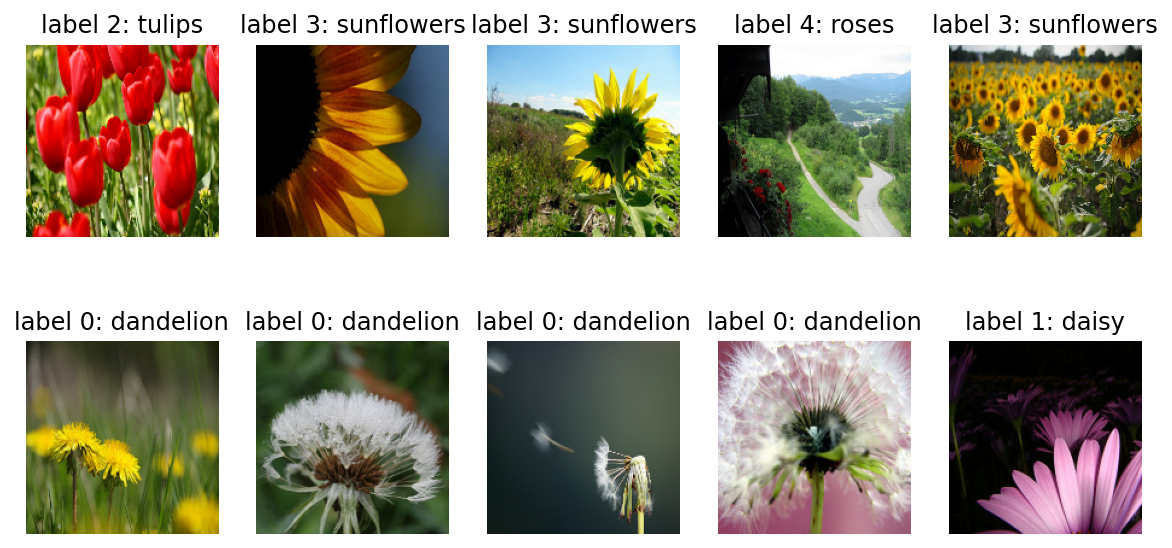

In [5]:
# 이미지 확인
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [6]:
# train_batches 요소 1개 차원 확인
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([20, 160, 160, 3]), TensorShape([20]))

In [7]:
# validation_batches 요소 1개 차원 확인
for image_batch, label_batch in validation_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([20, 160, 160, 3]), TensorShape([20]))

## 모델 설계하기

In [8]:
# TODO: 모델 변경 (VGG16)
# TODO: class의 갯수가 5가지. 모델 설계 시 어느 부분이 달라질 것인가?

# 직접 만든 모델: 사용하지 않음
'''
model = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)), 
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'), 
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'), 
    MaxPooling2D(),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=2, activation='softmax')
])
'''

# VGG16
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                   include_top=False, # output에 가까운 높은 레벨 FC 레이어 3개 제외
                                   weights='imagenet')


# base_model 구조 확인
base_model.summary() 

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [9]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax') # 변경: 2 -> 5 (# of class)

base_model.trainable = False

# 최종 모델
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dense_layer,
    prediction_layer
])

# 최종 모델 구조 확인
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


## 모델 compile 및 학습

### compile

In [10]:
base_learning_rate = 0.001 # 변경: 0.0001 -> 0.001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

### 학습

In [11]:
validation_steps = 10 # 변경: 20 -> 10
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

10/10 [==============================] - 0s 43ms/step - loss: 1.7990 - accuracy: 0.1250
initial loss: 1.80
initial accuracy: 0.12


In [12]:
EPOCHS = 5 # 변경: 10 -> 5
history = model.fit(train_batches, 
                    epochs=EPOCHS, 
                    validation_data=validation_batches)

Epoch 1/5
147/147 [==============================] - 35s 239ms/step - loss: 0.8468 - accuracy: 0.6866 - val_loss: 0.6180 - val_accuracy: 0.7766
Epoch 2/5
147/147 [==============================] - 8s 57ms/step - loss: 0.5614 - accuracy: 0.7973 - val_loss: 0.7487 - val_accuracy: 0.7193
Epoch 3/5
147/147 [==============================] - 8s 57ms/step - loss: 0.4846 - accuracy: 0.8229 - val_loss: 0.5129 - val_accuracy: 0.8147
Epoch 4/5
147/147 [==============================] - 8s 57ms/step - loss: 0.4307 - accuracy: 0.8443 - val_loss: 0.4979 - val_accuracy: 0.8202
Epoch 5/5
147/147 [==============================] - 9s 58ms/step - loss: 0.3962 - accuracy: 0.8549 - val_loss: 0.4496 - val_accuracy: 0.8392


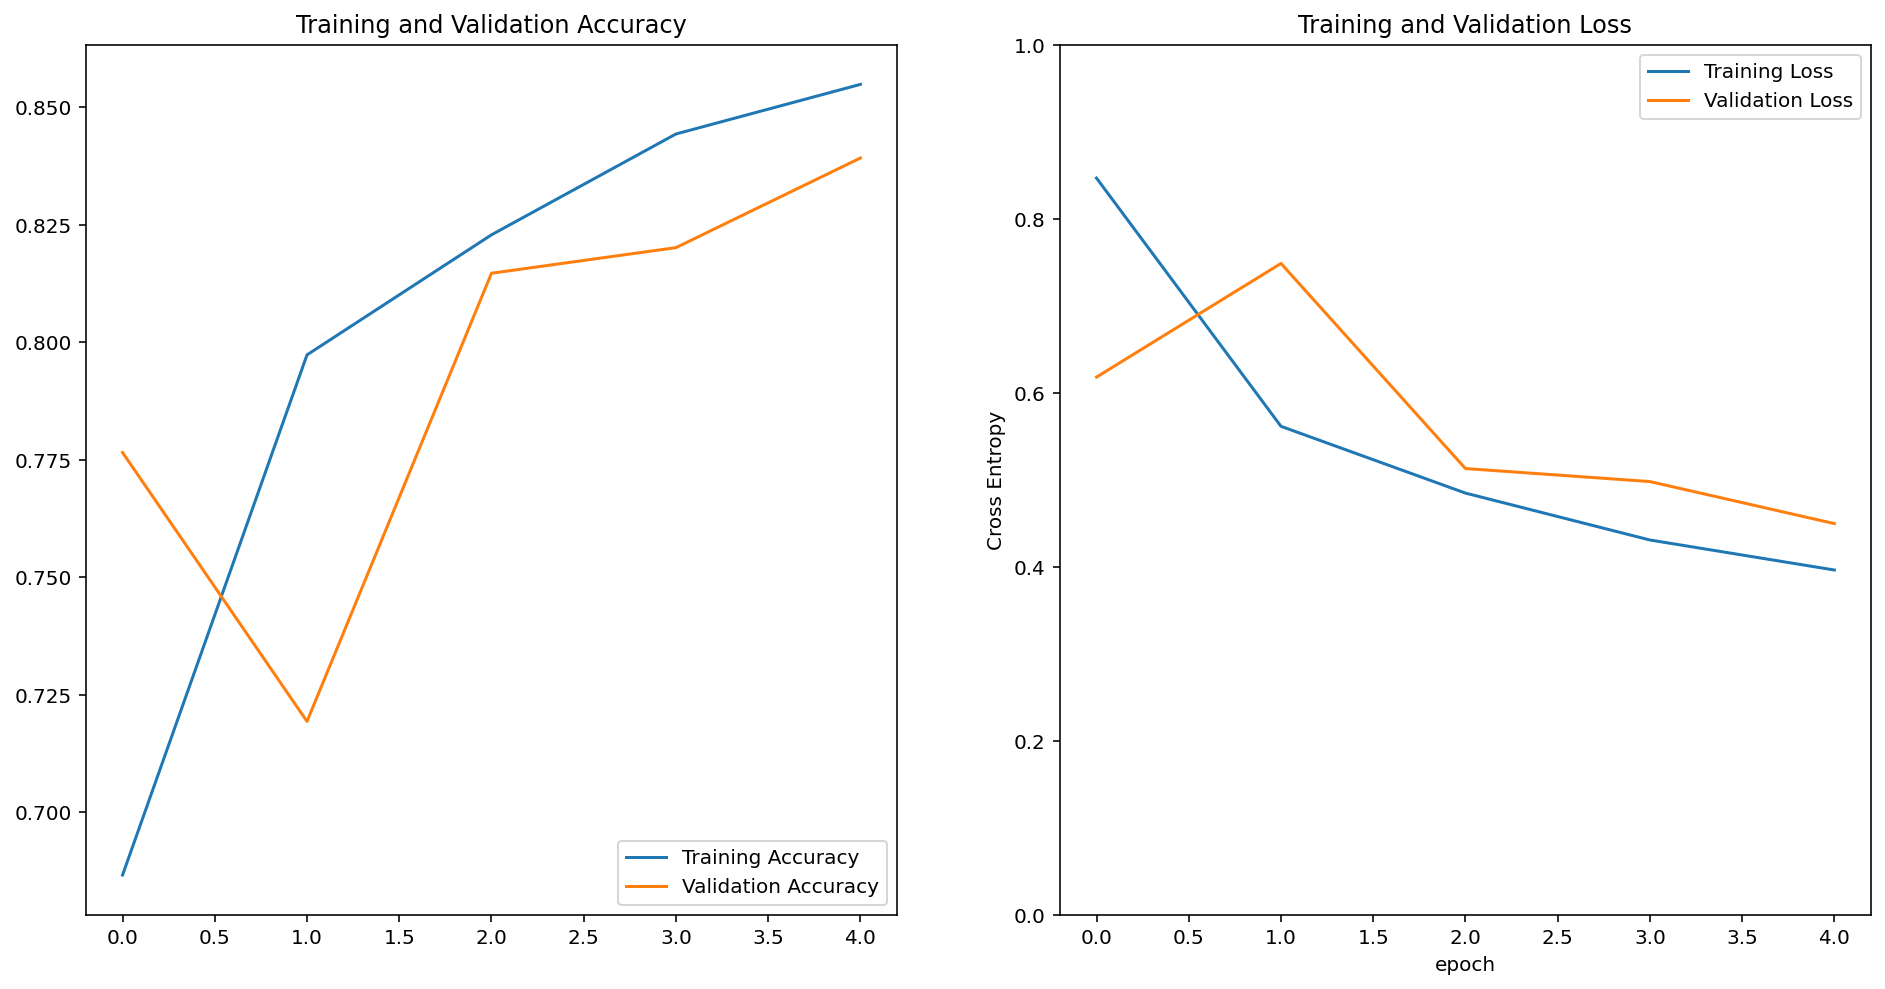

In [13]:
# 학습 단계에 따른 정확도 확인
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
# 테스트
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[3.0877942e-03, 2.9305659e-02, 8.5655499e-01, 4.8378767e-03,
        1.0621366e-01],
       [9.9991465e-01, 8.0222577e-05, 2.0556209e-07, 3.6550574e-07,
        4.4869244e-06],
       [6.2539518e-01, 2.4206105e-01, 1.9854244e-02, 8.9595817e-02,
        2.3093624e-02],
       [2.2581710e-04, 1.0876192e-03, 5.9394377e-01, 5.1379221e-04,
        4.0422902e-01],
       [6.2850040e-01, 3.5573712e-01, 4.9253195e-03, 3.6220753e-03,
        7.2151031e-03],
       [9.5815217e-01, 3.3438377e-02, 9.9995383e-04, 7.0770178e-03,
        3.3247171e-04],
       [1.7394847e-03, 1.7643335e-03, 9.7320461e-01, 1.1882489e-02,
        1.1409158e-02],
       [1.8688652e-01, 8.0433989e-01, 7.7081160e-05, 8.2208971e-03,
        4.7563500e-04],
       [1.7191935e-03, 3.1681042e-04, 1.6271511e-02, 9.3999255e-01,
        4.1699905e-02],
       [9.9986935e-01, 1.2916386e-04, 2.2494535e-07, 8.0103581e-07,
        3.8022517e-07],
       [9.7180623e-01, 2.6496716e-02, 2.3003184e-04, 1.2291794e-03,
        2.37

In [15]:
# test accuracy 확인
predictions = np.argmax(predictions, axis=1)

count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 20 * 100) # BATCH_SIZE == 20 이므로

95.0
